In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
dog_df = pd.read_csv("../../main_data/locale_specific_data/Sonoma_nontime_cleaned_ry.csv").drop(["Unnamed: 0"], axis=1)


### Question we are trying to answer: *Can we predict the likelihood of adoption of dogs in an animal shelter?*

- X: any features in dataframe
- y: "outcome_adopt"


### Try: Decision Tree Classification

In [15]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


In [19]:
X_t, X_h, y_t, y_h = train_test_split(dog_df.drop('outcome_adopt', axis=1),
                                      dog_df.outcome_adopt,
                                      shuffle=True,
                                      stratify=dog_df.outcome_adopt,
                                      test_size=0.2)


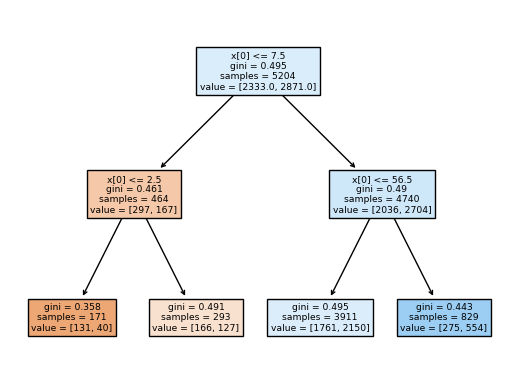

<Figure size 640x480 with 0 Axes>

In [20]:

dog_tree = DecisionTreeClassifier(max_depth=2).fit(X=X_t.days_in_shelter.values.reshape(-1,1),
                                                   y=y_t.values)

tree.plot_tree(dog_tree, filled=True)
plt.show()
plt.clf()

del dog_tree

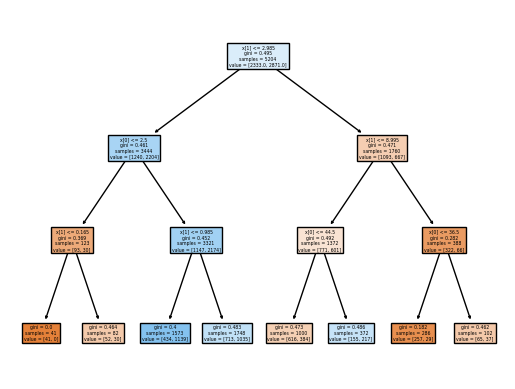

<Figure size 640x480 with 0 Axes>

In [21]:
dog_tree = DecisionTreeClassifier(max_depth=3).fit(X=X_t[['days_in_shelter','intake_age']],
                                                   y=y_t.values)

tree.plot_tree(dog_tree, filled=True)
plt.show()
plt.clf()

del dog_tree

### Try: RandomForest Classification

In [59]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score


In [32]:
dog_df['sex_bin'] = 1*(dog_df.sex=="Female")


In [36]:
size_dict = {'PUPPY':0, 'TOY':1, 'SMALL':2, 'MED':3, 'LARGE':4,'X-LRG':5}
dog_df['size_bin'] = dog_df['size'].map(size_dict)
del size_dict

In [37]:
feature_list = ['sex_bin','size_bin','days_in_shelter','dob_season','intake_season','outcome_season','intake_age','outcome_age','pop_control']
# outcome = 'outcome_adopt'

In [38]:
dog_df[feature_list].sample(5)

,sex_bin,size_bin,days_in_shelter,dob_season,intake_season,outcome_season,intake_age,outcome_age,pop_control
5942,0,3,39,1,0,1,4.83,4.94,1
408,1,5,12,1,1,1,2.96,3.00,1
1090,0,2,43,2,0,0,9.47,9.59,1
5236,0,4,237,3,2,1,1.86,2.51,1
4190,1,2,27,1,0,1,4.93,5.00,1


In [39]:
X_t, X_h, y_t, y_h = train_test_split(dog_df[feature_list],
                                      dog_df.outcome_adopt,
                                      shuffle=True,
                                      stratify=dog_df.outcome_adopt,
                                      test_size=0.2)

In [40]:
forst = RandomForestClassifier(n_estimators=500, max_depth=5).fit(X_t, y_t)

In [41]:
score_df = pd.DataFrame({'feature':X_t.columns,
'importance':forst.feature_importances_})

score_df.sort_values('importance', ascending=False)

,feature,importance
8,pop_control,0.651119
6,intake_age,0.126827
7,outcome_age,0.126278
2,days_in_shelter,0.043644
1,size_bin,0.037301
0,sex_bin,0.006230
5,outcome_season,0.003240
3,dob_season,0.002825
4,intake_season,0.002536


In [42]:
feature_list = ['sex_bin','size_bin','days_in_shelter','dob_season','intake_season','outcome_season','intake_age','outcome_age']

X_t, X_h, y_t, y_h = train_test_split(dog_df[feature_list],
                                      dog_df.outcome_adopt,
                                      shuffle=True,
                                      stratify=dog_df.outcome_adopt,
                                      test_size=0.2)

forst = RandomForestClassifier(n_estimators=500, max_depth=5).fit(X_t, y_t)

score_df = pd.DataFrame({'feature':X_t.columns,
'importance':forst.feature_importances_})

score_df.sort_values('importance', ascending=False)

,feature,importance
6,intake_age,0.345271
7,outcome_age,0.329086
2,days_in_shelter,0.163482
1,size_bin,0.100296
0,sex_bin,0.018784
5,outcome_season,0.015488
3,dob_season,0.014390
4,intake_season,0.013204


In [54]:
adopt_prob = forst.predict_proba(X_t)[:, 1]

adopt_pred = 1 * (adopt_prob > 2/3 )

np.sum(adopt_pred == y_t.values)/len(y_t)

0.6028055342044581

In [55]:
accuracy_score(y_pred = adopt_pred, y_true = y_t)

0.6028055342044581

In [58]:
feature_list = ['sex_bin','size_bin','days_in_shelter','outcome_season','intake_age']

X_t, X_h, y_t, y_h = train_test_split(dog_df[feature_list],
                                      dog_df.outcome_adopt,
                                      shuffle=True,
                                      stratify=dog_df.outcome_adopt,
                                      test_size=0.2)

for DEP in range(3, 12):
    forst = RandomForestClassifier(n_estimators=500, max_depth=DEP).fit(X_t, y_t)

    #score_df = pd.DataFrame({'feature':X_t.columns, 'importance':forst.feature_importances_})

    adopt_pred = 1 * (forst.predict_proba(X_t)[:, 1] > 2/3 )
    #print( score_df.sort_values('importance', ascending=False) )

    print( DEP, round(accuracy_score(y_pred = adopt_pred, y_true = y_t), 2))

3 0.54
4 0.59
5 0.62
6 0.65
7 0.68
8 0.71
9 0.75
10 0.78
11 0.82


#### Keep current feature_list and 20% test split, change cutoff hyperparameter

In [61]:
feature_list = ['sex_bin','size_bin','days_in_shelter','outcome_season','intake_age']

X_t, X_h, y_t, y_h = train_test_split(dog_df[feature_list],
                                      dog_df.outcome_adopt,
                                      shuffle=True,
                                      stratify=dog_df.outcome_adopt,
                                      test_size=0.2)


In [62]:
adoption_prob_cutoff = 2/3

for DEP in range(3, 12):
    rf_forst = RandomForestClassifier(n_estimators=500, max_depth=DEP).fit(X_t, y_t)
    et_forst = ExtraTreesClassifier(n_estimators=500, max_depth=DEP).fit(X_t, y_t)

    #score_df = pd.DataFrame({'feature':X_t.columns, 'importance':forst.feature_importances_})
    #print( score_df.sort_values('importance', ascending=False) )

    rf_adopt_pred = 1 * (rf_forst.predict_proba(X_t)[:, 1] > adoption_prob_cutoff )
    print( "RandomForest: ", DEP, round(accuracy_score(y_pred = rf_adopt_pred, y_true = y_t), 2))

    et_adopt_pred = 1 * (et_forst.predict_proba(X_t)[:, 1] > adoption_prob_cutoff )
    print( "ExtraForest: ", DEP, round(accuracy_score(y_pred = et_adopt_pred, y_true = y_t), 2))

    del rf_forst, rf_adopt_pred, et_forst, et_adopt_pred
    print()

RandomForest:  3 0.53
ExtraForest:  3 0.47

RandomForest:  4 0.6
ExtraForest:  4 0.49

RandomForest:  5 0.63
ExtraForest:  5 0.51

RandomForest:  6 0.66
ExtraForest:  6 0.53

RandomForest:  7 0.69
ExtraForest:  7 0.55

RandomForest:  8 0.72
ExtraForest:  8 0.58

RandomForest:  9 0.76
ExtraForest:  9 0.61

RandomForest:  10 0.79
ExtraForest:  10 0.65

RandomForest:  11 0.82
ExtraForest:  11 0.7



In [63]:
adoption_prob_cutoff = 1/2

for DEP in range(3, 12):
    rf_forst = RandomForestClassifier(n_estimators=500, max_depth=DEP).fit(X_t, y_t)
    et_forst = ExtraTreesClassifier(n_estimators=500, max_depth=DEP).fit(X_t, y_t)

    #score_df = pd.DataFrame({'feature':X_t.columns, 'importance':forst.feature_importances_})
    #print( score_df.sort_values('importance', ascending=False) )

    rf_adopt_pred = 1 * (rf_forst.predict_proba(X_t)[:, 1] > adoption_prob_cutoff )
    print( "RandomForest: ", DEP, round(accuracy_score(y_pred = rf_adopt_pred, y_true = y_t), 2))

    et_adopt_pred = 1 * (et_forst.predict_proba(X_t)[:, 1] > adoption_prob_cutoff )
    print( "ExtraForest: ", DEP, round(accuracy_score(y_pred = et_adopt_pred, y_true = y_t), 2))

    del rf_forst, rf_adopt_pred, et_forst, et_adopt_pred
    print()

RandomForest:  3 0.68
ExtraForest:  3 0.64

RandomForest:  4 0.69
ExtraForest:  4 0.65

RandomForest:  5 0.7
ExtraForest:  5 0.66

RandomForest:  6 0.71
ExtraForest:  6 0.67

RandomForest:  7 0.73
ExtraForest:  7 0.68

RandomForest:  8 0.75
ExtraForest:  8 0.7

RandomForest:  9 0.78
ExtraForest:  9 0.71

RandomForest:  10 0.82
ExtraForest:  10 0.74

RandomForest:  11 0.85
ExtraForest:  11 0.77

